# Logistic Regression and SGD Homework 
***
**Name**: Akriti Kapur 
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [3]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        self.x[0] = 1

def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [4]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)

In [24]:
print('Number of words in the vocabulary - {}'.format(len(vocab)))
print('Uses a bag of words model. The number of features are the length of the vocabulary.' + 
      'For each sentence in the positive and negative files (which already has the count of unique words),' +
      'the features are words, where the index of the word in the feature list (vocab list) contains' + 
      'the number of times that word occurs in the sentence.')
print('Motorcycle has a label 1 , Automobile - 0')

Number of words in the vocabulary - 5327
Uses a bag of words model. The number of features are the length of the vocabulary.For each sentence in the positive and negative files (which already has the count of unique words),the features are words, where the index of the word in the feature list (vocab list) containsthe number of times that word occurs in the sentence.
Motorcycle has a label 1 , Automobile - 0


### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [6]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = dict()

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
        
        # dict to store the last updated iteration of feature
        self.memory = {}
        
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                iteration += 1
    
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
        muu = (self.sigmoid(np.dot(self.w, train_example.x)) - train_example.y)
        dw = muu * train_example.x
        
        # shrinkage factor
        shrinkage_factor = 1 - 2 * self.eta * self.lam

        # Unregularized update
        self.w = self.w - self.eta * dw
    
        # Assign prior value to feature if index not present in dictionary.
        for feature in range(1, len(train_example.x)):
            if not feature in self.memory:
                self.memory[feature] = -1
        
        for index in range(1, len(train_example.x)):
            if train_example.x[index] != 0:
                # if x is non-zero, perform update to weight.
                self.w[index] = self.w[index] * pow(shrinkage_factor, iteration - self.memory[index])
                # update last modified iteration for feature.
                self.memory[index] = iteration
        

In [44]:
lr = LogReg(train_set, test_set, lam=0.0001, eta=0.1)
lr.train(isVerbose=True)

Update     0  TrnNLL  780.063  TstNLL   82.186  TrnA 0.498  TstA 0.534
Update     5  TrnNLL  641.735  TstNLL   72.313  TrnA 0.656  TstA 0.595
Update    10  TrnNLL  589.605  TstNLL   69.778  TrnA 0.699  TstA 0.664
Update    15  TrnNLL  482.610  TstNLL   59.459  TrnA 0.795  TstA 0.707
Update    20  TrnNLL  457.335  TstNLL   55.791  TrnA 0.827  TstA 0.819
Update    25  TrnNLL  440.447  TstNLL   54.290  TrnA 0.832  TstA 0.802
Update    30  TrnNLL  414.295  TstNLL   54.906  TrnA 0.839  TstA 0.784
Update    35  TrnNLL  424.344  TstNLL   54.722  TrnA 0.824  TstA 0.776
Update    40  TrnNLL  399.801  TstNLL   51.861  TrnA 0.832  TstA 0.784
Update    45  TrnNLL  398.699  TstNLL   51.742  TrnA 0.830  TstA 0.793
Update    50  TrnNLL  391.115  TstNLL   47.598  TrnA 0.844  TstA 0.819
Update    55  TrnNLL  375.603  TstNLL   45.479  TrnA 0.851  TstA 0.845
Update    60  TrnNLL  368.311  TstNLL   44.440  TrnA 0.859  TstA 0.828
Update    65  TrnNLL  369.958  TstNLL   44.950  TrnA 0.855  TstA 0.836
Update

Update   585  TrnNLL  130.169  TstNLL   21.325  TrnA 0.959  TstA 0.931
Update   590  TrnNLL  130.347  TstNLL   20.398  TrnA 0.956  TstA 0.922
Update   595  TrnNLL  123.116  TstNLL   21.008  TrnA 0.957  TstA 0.922
Update   600  TrnNLL  123.077  TstNLL   20.891  TrnA 0.957  TstA 0.922
Update   605  TrnNLL  121.852  TstNLL   20.948  TrnA 0.960  TstA 0.922
Update   610  TrnNLL  121.039  TstNLL   21.626  TrnA 0.962  TstA 0.922
Update   615  TrnNLL  121.339  TstNLL   21.783  TrnA 0.961  TstA 0.922
Update   620  TrnNLL  121.199  TstNLL   21.746  TrnA 0.962  TstA 0.922
Update   625  TrnNLL  122.921  TstNLL   22.041  TrnA 0.962  TstA 0.922
Update   630  TrnNLL  122.859  TstNLL   22.029  TrnA 0.962  TstA 0.922
Update   635  TrnNLL  121.506  TstNLL   21.393  TrnA 0.962  TstA 0.914
Update   640  TrnNLL  121.354  TstNLL   21.324  TrnA 0.962  TstA 0.914
Update   645  TrnNLL  123.922  TstNLL   21.387  TrnA 0.963  TstA 0.897
Update   650  TrnNLL  121.531  TstNLL   20.540  TrnA 0.966  TstA 0.914
Update

The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [7]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.010s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [8]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

regularization values used - [0, 1e-07, 5e-07, 1e-06, 2e-06, 3e-06, 4e-06, 4.5e-06, 4.8e-06, 5e-06, 6e-06, 7e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005]
accuracy- ['0.960', '0.957', '0.954', '0.960', '0.954', '0.948', '0.945', '0.954', '0.963', '0.963', '0.957', '0.966', '0.963', '0.954', '0.954', '0.951', '0.957', '0.948']


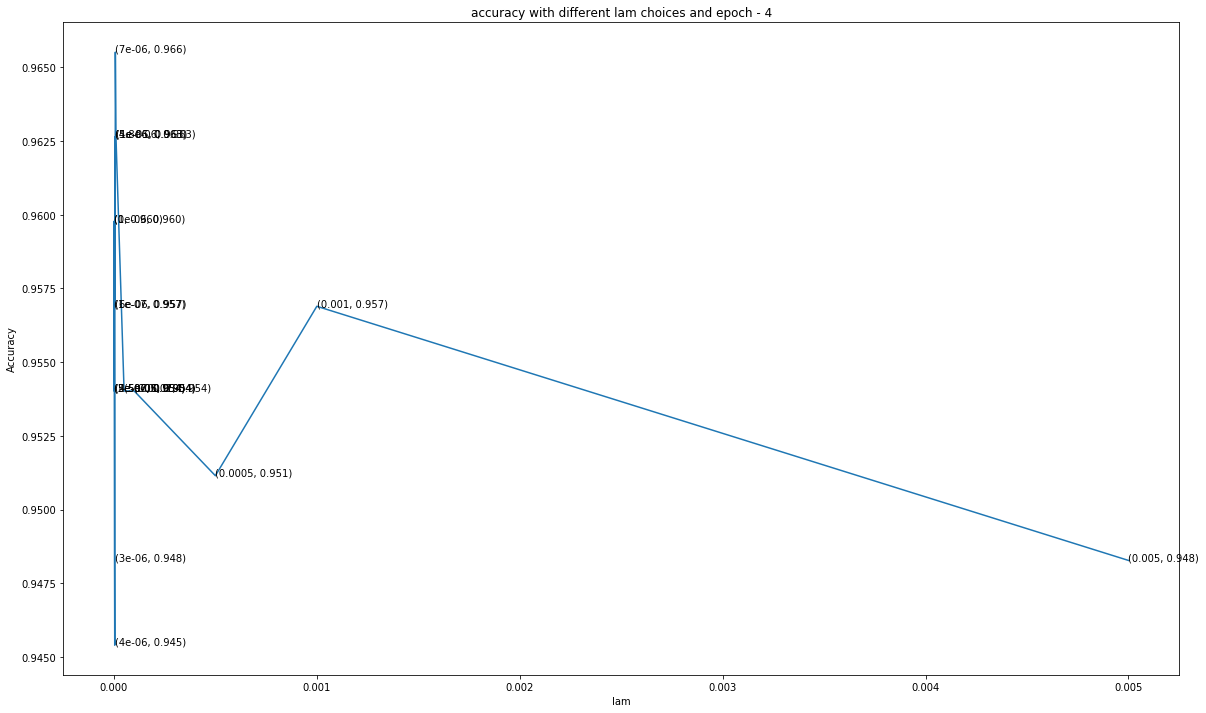

In [23]:

lam_choices = [0, 0.0000001, 0.0000005, 0.000001, 0.000002, 0.000003, 0.000004, 0.0000045, 0.0000048, 0.000005, 0.000006, 0.000007, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005]
epochs = [4]
train_set_len = len(train_set)
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)
# print(train_set_len)
accuracy = []
for epoch in epochs:
    accuracy = []
    for choice in lam_choices:
        lr = LogReg(train_set, test_set, lam=choice, eta=0.1)
        lr.train(num_epochs=epoch, report_step=train_set_len)
#         print(lr.test_acc[1:])
        avg_test_nll = np.average(lr.test_nll[1:])
        avg_test_acc = np.average(lr.test_acc[1:])
        accuracy.append(avg_test_acc)
#         print('lam: {}, NLL: {}, Accuracy: {}'.format(choice, avg_test_nll, avg_test_acc))
    
    print('regularization values used -', lam_choices)
    print('accuracy-', ["{0:.3f}".format(a) for a in accuracy])
    plt.title('accuracy with different lam choices and epoch - {}'.format(epoch))
    plt.plot(lam_choices, accuracy)
    plt.xlabel('lam')
    plt.ylabel('Accuracy')
    for i,j in zip(lam_choices,accuracy):
        ax.annotate('({}, {})'.format(i, "{0:.3f}".format(j)), xy=(i, j), textcoords='data')

#     plt.grid()
    plt.show()
    
    """
    Based on the graph, the value of regularization that gives the highest accuracy lies
    in the window [4.5 * 10^(-6), 7*10^(-6)]. These consistently show good performance. Although sometimes,
    random values tend to do well.
    """



    
    

**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

In [9]:
from collections import defaultdict
iteration = 0
num_epochs = 6
report_step = 3

eta_choices = [0.01, 0.02, 0.04, 0.05, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

threshold = 0.002


has_converged = False
eta_i = defaultdict(list)
for i in range(5):
    for eta in eta_choices:
        lr = LogReg(train_set, test_set, lam=0.001, eta=eta)
        has_converged = False
        last_saved_weights = lr.w
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):  
            np.random.shuffle(lr.train_set)
            # loop over each training example
            for ex in lr.train_set:
                # perform SGD update of weights 
                lr.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    diff_arr = np.abs(last_saved_weights - lr.w)
    #                 print(diff_arr)
                    if all(a <= threshold  for a in diff_arr):
                        eta_i[eta].append(iteration)
                        has_converged = True
                        break
                    last_saved_weights = lr.w

                iteration += 1
            if has_converged:
                break

print(eta_i)

defaultdict(<class 'list'>, {0.01: [1150, 736, 775, 1123, 1291], 0.02: [715, 529, 829, 1051, 829], 0.04: [796, 466, 829, 559, 961], 0.05: [805, 880, 508], 0.06: [3250]})


### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [7]:
train_set_len = len(train_set)
lr = LogReg(train_set, test_set, lam=0, eta=0.1)
lr.train(num_epochs=8, report_step=train_set_len)
sorted_indices = np.argsort(lr.w)
motorcycle_indices = sorted_indices[-10:]
motorcycle_words = [vocab[i] for i in reversed(motorcycle_indices)]
automobile_indices = sorted_indices[:10]
automobile_words = [vocab[i] for i in automobile_indices]
print('top 10 words(best predictors) in dec order for motorcycle - ', motorcycle_words)
print('top 10 words(best predictors)  in dec order for automobile - ', automobile_words)

top 10 words(best predictors) in dec order for motorcycle -  ['dod', 'bike', 'bikes', 'ride', 'riding', 'denizens', 'doom', 'jonathan', 'terrible', 'digest']
top 10 words(best predictors)  in dec order for automobile -  ['requests', 'car', 'send', 'cars', 'welty', 'school', 'mailing', 'radar', 'request', 'toyota']


**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [15]:
len_indices = len(sorted_indices)
int(len_indices/2)+5
worst_pred_indices = sorted_indices[int(len_indices/2)-5: int(len_indices/2)+5]
print('10 words that are worst predictors for a class are', [vocab[i] for i in worst_pred_indices])

10 words that are worst predictors for a class are ['goodyear', 'attract', '1960s', 'inner', 'orleans', 'rebel', 'eagles', 'fold', 'agreement', 'approved']
